In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 pandapower==2.14.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 100.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 113.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 55.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 120.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78

In [2]:
pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandapower as pp, pickle

net = pp.networks.case6ww()
with open("pandapower_net.pkl", "wb") as f:
    pickle.dump(net, f)
print("Saved pandapower_net.pkl")


Saved pandapower_net.pkl


In [5]:
# ============================================================
# constrained_stochastic_ddim_from_data_single_model.py
# ============================================================
# Stochastic DDIM with physics guidance for power flow data.
# Single denoiser model for the full state vector.
# ============================================================

import os, math, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from sklearn.model_selection import train_test_split

# ---------------- CONFIG ----------------
DATA_CSV = "/kaggle/input/case6-ieee/test_data_6.csv"
YBUS_NPZ = "Ybus.npz"
PANDAPOWER_NET_PKL = "pandapower_net.pkl"
OUT_CSV = "ddpm_stochastic_constrained_generated.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_BUS = 6
NUM_FEATURES = 4 * NUM_BUS
BATCH_SIZE = 64
EPOCHS = 1000
LR = 1e-4
TIMESTEPS = 1000
SAMPLE_COUNT = 5000
GUIDANCE_LAMBDA = 1e-4
# ----------------------------------------

# ---------- Load dataset ----------
if not os.path.exists(DATA_CSV):
    raise FileNotFoundError("Need actual_data.csv generated from PF dataset code.")
df = pd.read_csv(DATA_CSV)
cols = df.columns.tolist()
if df.shape[1] != NUM_FEATURES:
    raise ValueError(f"Dataset must have {NUM_FEATURES} columns.")
data = df.values.astype(np.float32)

# ---------- Load Ybus ----------
def load_ybus():
    if os.path.exists(YBUS_NPZ):
        arr = np.load(YBUS_NPZ)
        return arr["G"].astype(np.float64), arr["B"].astype(np.float64)
    if os.path.exists(PANDAPOWER_NET_PKL):
        import pandapower as pp
        with open(PANDAPOWER_NET_PKL, "rb") as f:
            net = pickle.load(f)
        nb = len(net.bus)
        Y = np.zeros((nb, nb), dtype=complex)
        for _, row in net.line.iterrows():
            i, j = int(row["from_bus"]), int(row["to_bus"])
            r, x = row["r_ohm_per_km"], row["x_ohm_per_km"]
            length = row.get("length_km", 1.0)
            y = 1 / complex(r * length, x * length)
            Y[i, i] += y; Y[j, j] += y; Y[i, j] -= y; Y[j, i] -= y
        return np.real(Y), np.imag(Y)
    raise FileNotFoundError("Need Ybus.npz or pandapower_net.pkl for guidance.")

G_np, B_np = load_ybus()
G = torch.tensor(G_np, dtype=torch.float32, device=DEVICE)
B = torch.tensor(B_np, dtype=torch.float32, device=DEVICE)

# ---------- Normalization ----------
xmin, xmax = data.min(axis=0), data.max(axis=0)
range_eps = (xmax - xmin).copy()
range_eps[range_eps == 0] = 1e-6

def normalize(x):  
    return 2 * (x - xmin) / range_eps - 1

def denormalize(xn):  
    return ((xn + 1) / 2) * range_eps + xmin

data_tensor = torch.tensor(normalize(data), dtype=torch.float32, device=DEVICE)

# ---------- Inequality bounds (from dataset) ----------
p_min = torch.tensor(xmin[:NUM_BUS], device=DEVICE, dtype=torch.float32)
p_max = torch.tensor(xmax[:NUM_BUS], device=DEVICE, dtype=torch.float32)
q_min = torch.tensor(xmin[NUM_BUS:2*NUM_BUS], device=DEVICE, dtype=torch.float32)
q_max = torch.tensor(xmax[NUM_BUS:2*NUM_BUS], device=DEVICE, dtype=torch.float32)
v_min = torch.tensor(xmin[2*NUM_BUS:3*NUM_BUS], device=DEVICE, dtype=torch.float32)
v_max = torch.tensor(xmax[2*NUM_BUS:3*NUM_BUS], device=DEVICE, dtype=torch.float32)

# ---------- Helpers ----------
def split_vec(x):
    p, q, v, th = x[:, :NUM_BUS], x[:, NUM_BUS:2*NUM_BUS], \
                  x[:, 2*NUM_BUS:3*NUM_BUS], x[:, 3*NUM_BUS:4*NUM_BUS]
    return torch.cat([p, th], 1), torch.cat([q, v], 1)

def concat_vec(x1, x2):
    p, th = x1[:, :NUM_BUS], x1[:, NUM_BUS:]
    q, v  = x2[:, :NUM_BUS], x2[:, NUM_BUS:]
    return torch.cat([p, q, v, th], 1)

# ---------- Diffusion schedule ----------
def linear_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T, device=DEVICE)

betas = linear_beta_schedule(TIMESTEPS)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, 0)

# ---------- Denoiser model (single) ----------
class MLPDenoiser(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, 4096), nn.LayerNorm(4096), nn.SiLU(),
            nn.Linear(4096, dim)
        )

    def forward(self, x, t):
        t = t.float().unsqueeze(1) / TIMESTEPS  # Normalize timestep to [0,1]
        return self.net(torch.cat([x, t], 1))

model_dim = 4 * NUM_BUS
model = MLPDenoiser(model_dim).to(DEVICE)
opt = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3, betas=(0.9, 0.999))
mse = nn.MSELoss()

# ---------- Train / Validation split ----------
train_data, val_data = train_test_split(data_tensor, test_size=0.1, random_state=42)
Ntrain, Nval = train_data.shape[0], val_data.shape[0]

# ---------- Training loop with validation ----------
print("Training denoiser with validation monitoring...")
best_val = float("inf")

for ep in range(EPOCHS):
    model.train()
    perm = torch.randperm(Ntrain, device=DEVICE)
    tot_loss = 0.0

    for i in range(0, Ntrain, BATCH_SIZE):
        b = train_data[perm[i:i+BATCH_SIZE]]   # full vector (BATCH, 4B)
        x = b
        Bc = x.size(0)
        if Bc == 0:
            continue

        # sample timesteps
        t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)

        # sample noise
        eps = torch.randn_like(x)

        sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
        sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)

        x_t = sA * x + sO * eps

        pred = model(x_t, t)

        loss = mse(pred, eps)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tot_loss += loss.item() * Bc

    train_loss = tot_loss / Ntrain

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i in range(0, Nval, BATCH_SIZE):
            b = val_data[i:i+BATCH_SIZE]
            x = b
            Bc = x.size(0)
            if Bc == 0:
                continue
            t = torch.randint(0, TIMESTEPS, (Bc,), device=DEVICE)
            eps = torch.randn_like(x)
            sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)
            sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)
            x_t = sA * x + sO * eps
            pred = model(x_t, t)
            val_loss += mse(pred, eps).item() * Bc
    val_loss /= Nval

    print(f"Epoch {ep+1:4d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save({
            "model": model.state_dict(),
            "opt": opt.state_dict(),
            "epoch": ep,
            "val_loss": val_loss
        }, "best_ddim_denoiser.pth")
        print(f"  New best model saved (val_loss={val_loss:.6f})")

print("Training done.\n")

Training denoiser with validation monitoring...
Epoch    1/1000 | Train Loss: 0.195955 | Val Loss: 0.119439
  New best model saved (val_loss=0.119439)
Epoch    2/1000 | Train Loss: 0.106851 | Val Loss: 0.122164
Epoch    3/1000 | Train Loss: 0.096175 | Val Loss: 0.103292
  New best model saved (val_loss=0.103292)
Epoch    4/1000 | Train Loss: 0.090584 | Val Loss: 0.081789
  New best model saved (val_loss=0.081789)
Epoch    5/1000 | Train Loss: 0.086140 | Val Loss: 0.079087
  New best model saved (val_loss=0.079087)
Epoch    6/1000 | Train Loss: 0.077998 | Val Loss: 0.070966
  New best model saved (val_loss=0.070966)
Epoch    7/1000 | Train Loss: 0.074829 | Val Loss: 0.079958
Epoch    8/1000 | Train Loss: 0.076193 | Val Loss: 0.074472
Epoch    9/1000 | Train Loss: 0.071201 | Val Loss: 0.074729
Epoch   10/1000 | Train Loss: 0.069405 | Val Loss: 0.071424
Epoch   11/1000 | Train Loss: 0.069734 | Val Loss: 0.077239
Epoch   12/1000 | Train Loss: 0.066399 | Val Loss: 0.066645
  New best model 

In [6]:
# ============================================================
# ONE-MODEL PHYSICS-GUIDED DDIM SAMPLER
# ============================================================

# ---------- Inequality bounds (from dataset) ----------
p_min_np = xmin[:NUM_BUS]
p_max_np = xmax[:NUM_BUS]
q_min_np = xmin[NUM_BUS:2*NUM_BUS]
q_max_np = xmax[NUM_BUS:2*NUM_BUS]
v_min_np = xmin[2*NUM_BUS:3*NUM_BUS]
v_max_np = xmax[2*NUM_BUS:3*NUM_BUS]

p_min = torch.tensor(p_min_np, device=DEVICE, dtype=torch.float32)
p_max = torch.tensor(p_max_np, device=DEVICE, dtype=torch.float32)
q_min = torch.tensor(q_min_np, device=DEVICE, dtype=torch.float32)
q_max = torch.tensor(q_max_np, device=DEVICE, dtype=torch.float32)
v_min = torch.tensor(v_min_np, device=DEVICE, dtype=torch.float32)
v_max = torch.tensor(v_max_np, device=DEVICE, dtype=torch.float32)


# ============================================================
# POWER FLOW RESIDUALS
# ============================================================

def power_residuals(x_den):
    p = x_den[:, :NUM_BUS]
    q = x_den[:, NUM_BUS:2*NUM_BUS]
    v = x_den[:, 2*NUM_BUS:3*NUM_BUS]
    th = x_den[:, 3*NUM_BUS:4*NUM_BUS]

    th_r = th * math.pi / 180

    vb = v.unsqueeze(-1)
    vj = v.unsqueeze(-2)

    dth = th_r.unsqueeze(-1) - th_r.unsqueeze(-2)
    cosd = torch.cos(dth)
    sind = torch.sin(dth)

    # AC power flow equations
    P = (vb * vj * (G * cosd + B * sind)).sum(-1)
    Q = (vb * vj * (G * sind - B * cosd)).sum(-1)

    return torch.cat([p - P, q - Q], dim=1)


def RH_sq(x_den):
    return (power_residuals(x_den) ** 2).sum(1)


def RG_sq(x_den):
    p = x_den[:, :NUM_BUS]
    q = x_den[:, NUM_BUS:2 * NUM_BUS]
    v = x_den[:, 2 * NUM_BUS:3 * NUM_BUS]

    viol_p_upper = torch.relu(p - p_max)
    viol_p_lower = torch.relu(p_min - p)
    viol_q_upper = torch.relu(q - q_max)
    viol_q_lower = torch.relu(q_min - q)
    viol_v_upper = torch.relu(v - v_max)
    viol_v_lower = torch.relu(v_min - v)

    viol = torch.cat(
        [
            viol_p_upper, viol_p_lower,
            viol_q_upper, viol_q_lower,
            viol_v_upper, viol_v_lower
        ],
        dim=1
    )

    return (viol ** 2).sum(1)


# ============================================================
#  SINGLE-MODEL DDIM SAMPLING WITH PHYSICS GUIDANCE
# ============================================================

def sample_constrained_ddpm(n_samples, lam=GUIDANCE_LAMBDA):
    model.eval()

    x_t = torch.randn(n_samples, NUM_FEATURES, device=DEVICE)

    re = torch.tensor(range_eps, device=DEVICE, dtype=torch.float32)
    xm = torch.tensor(xmin, device=DEVICE, dtype=torch.float32)

    for t_idx in tqdm(list(reversed(range(TIMESTEPS))), desc="Sampling"):
        t = torch.full((n_samples,), t_idx, device=DEVICE, dtype=torch.long)

        # -------- 1) Predict noise with ONE MODEL ----------
        with torch.no_grad():
            eps = model(x_t, t)        # single-model prediction

        sA = torch.sqrt(alphas_cumprod[t]).unsqueeze(1)       # sqrt(ā_t)
        sO = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(1)   # sqrt(1-ā_t)

        # -------- 2) Estimate x0 --------
        x0 = (x_t - sO * eps) / sA

        # -------- 3) Physics guidance on DENORMALIZED state --------
        x_den = ((x0 + 1.0) / 2.0) * re + xm
        x_den = x_den.detach().clone().requires_grad_(True)

        R_total = RH_sq(x_den) + RG_sq(x_den)

        g_phys = grad(R_total.sum(), x_den, retain_graph=False, create_graph=False)[0]

        grad_norm = g_phys * (re / 2.0)

        lam_t = lam * ((t.float() + 1.0) / TIMESTEPS).unsqueeze(1)

        x0_guided = x0 - lam_t * grad_norm
        x0_guided = torch.clamp(x0_guided, -1.0, 1.0)

        # -------- 4) DDIM posterior update --------
        a_t = alphas[t].unsqueeze(1)
        b_t = betas[t].unsqueeze(1)
        a_bar_t = alphas_cumprod[t].unsqueeze(1)

        if t_idx > 0:
            a_bar_prev = alphas_cumprod[t - 1].unsqueeze(1)
        else:
            a_bar_prev = torch.ones_like(a_bar_t)

        sigma_t = b_t * (1 - a_bar_prev) / (1 - a_bar_t)
        sigma_t = torch.clamp(sigma_t, min=0.0)

        coef_x = torch.sqrt(a_t) * (1 - a_bar_prev) / (1 - a_bar_t)
        coef_x0 = torch.sqrt(a_bar_prev) * b_t / (1 - a_bar_t)

        z = torch.randn_like(x_t) if t_idx > 0 else torch.zeros_like(x_t)

        x_t = coef_x * x_t + coef_x0 * x0_guided + torch.sqrt(sigma_t) * z

    gen_norm = x_t.detach().cpu().numpy()
    gen_denorm = denormalize(gen_norm)

    bad = ~np.isfinite(gen_denorm)
    if bad.any():
        print(f"[warn] {bad.sum()} invalid values detected; replacing with finite.")
        gen_denorm = np.nan_to_num(gen_denorm)

    return gen_denorm


# ============================================================
#  GENERATE + SAVE
# ============================================================

print("Sampling with SINGLE-model guidance...")
gen = sample_constrained_ddpm(SAMPLE_COUNT, lam=GUIDANCE_LAMBDA)

assert gen.shape == (SAMPLE_COUNT, NUM_FEATURES)

pd.DataFrame(gen, columns=cols).to_csv(OUT_CSV, index=False)

print(f"\nGenerated {len(gen)} samples saved to {OUT_CSV}")


Sampling with SINGLE-model guidance...


Sampling: 100%|██████████| 1000/1000 [00:52<00:00, 19.05it/s]



Generated 5000 samples saved to ddpm_stochastic_constrained_generated.csv



Detected 6 buses based on column naming (P1...P6).

Converted per-unit values to actual units (MW / Mvar / kV / degrees)


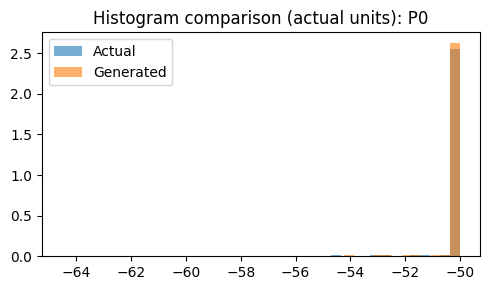

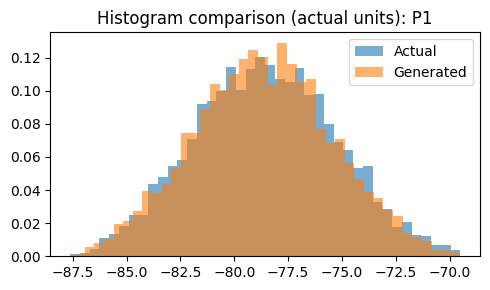

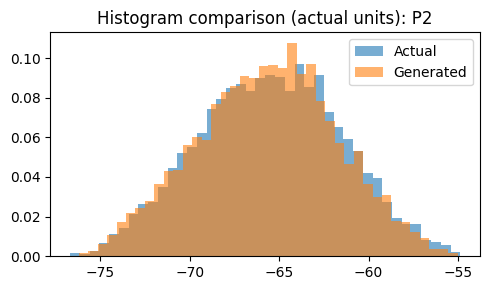

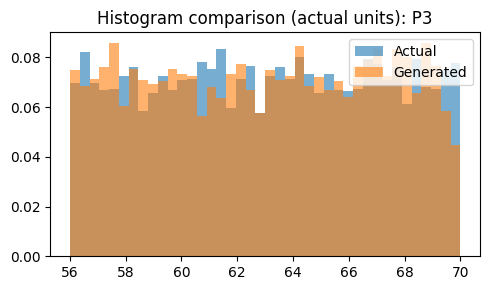

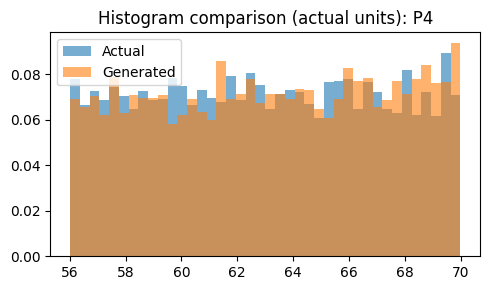

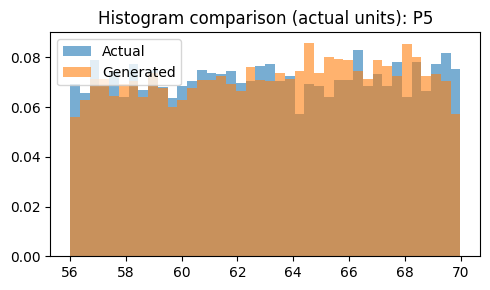

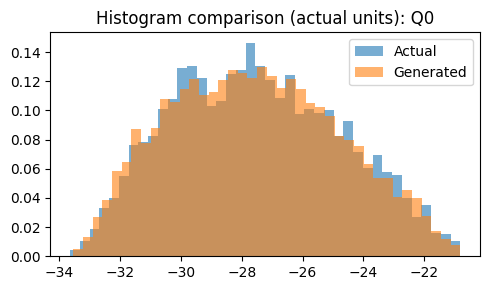

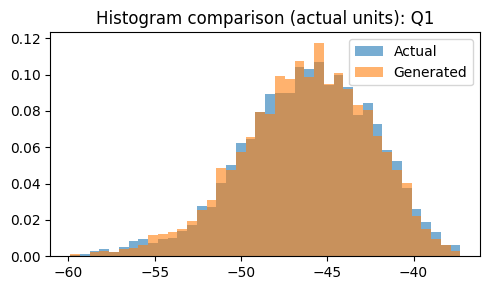

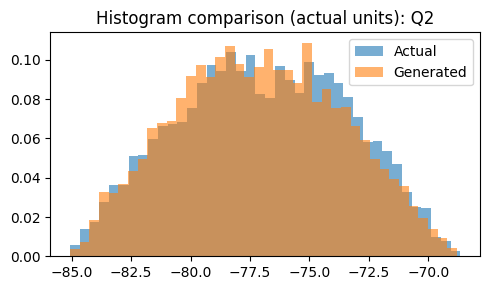

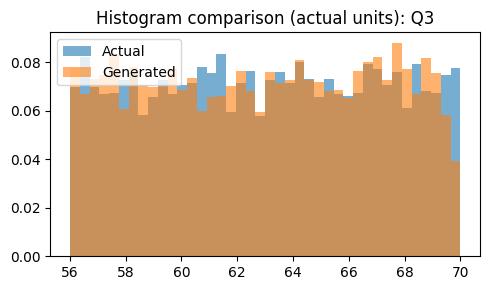

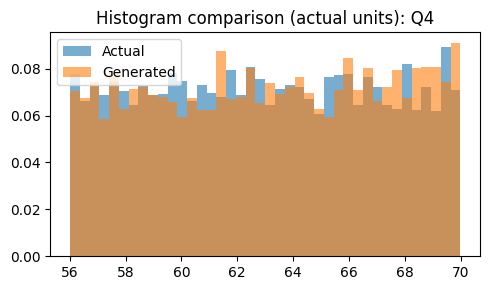

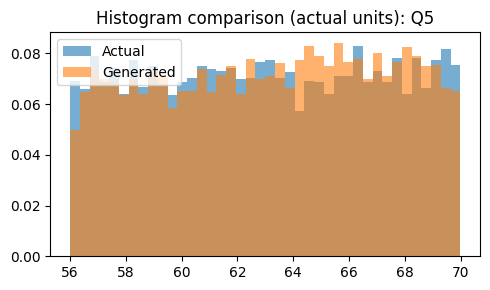

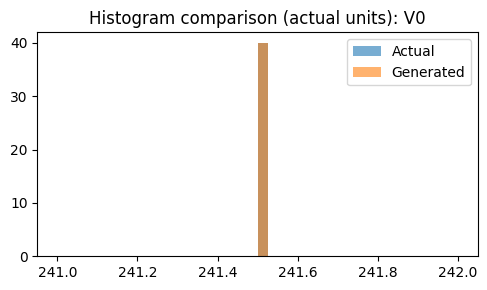

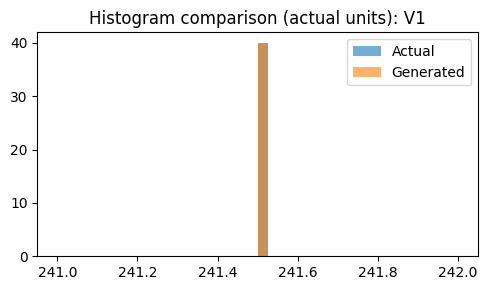

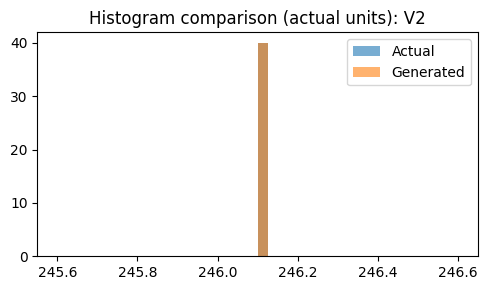

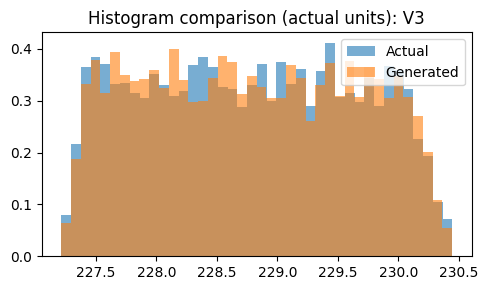

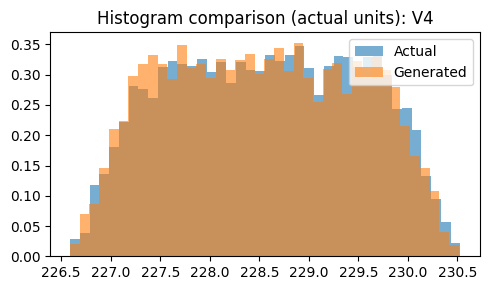

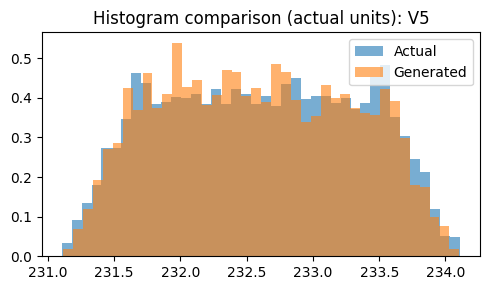

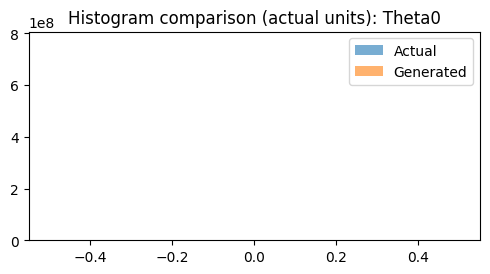

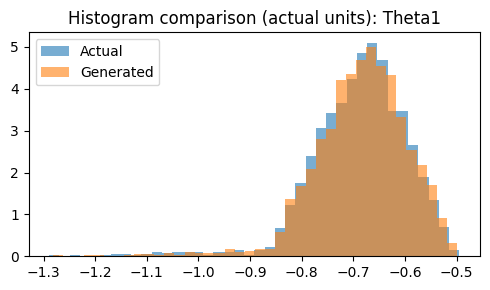

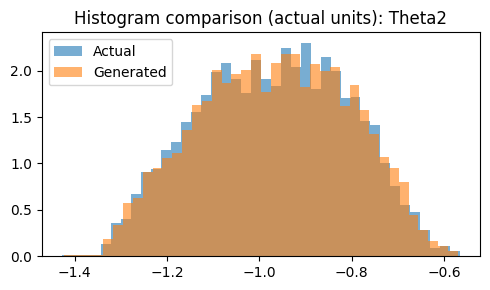

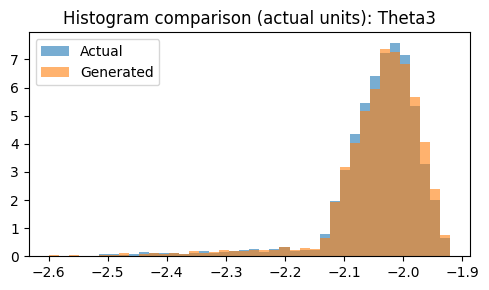

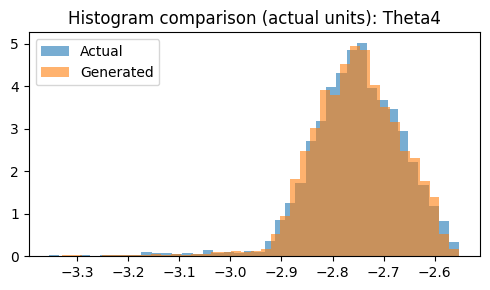

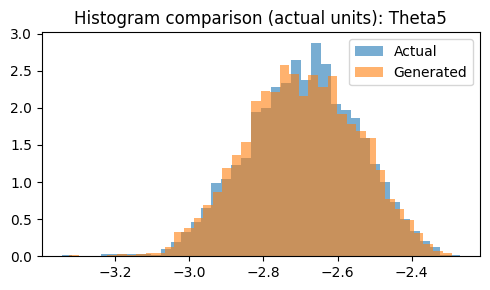

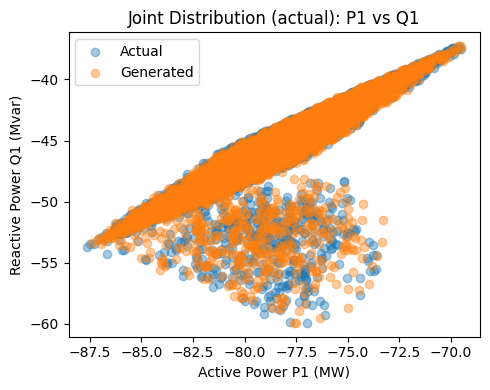

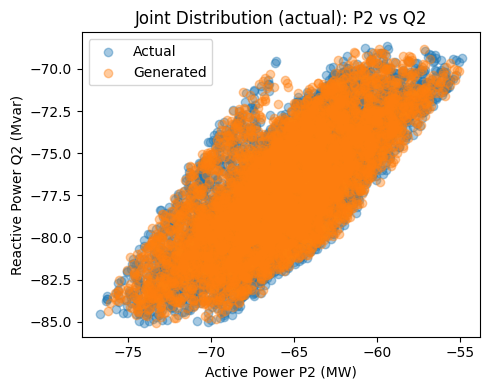

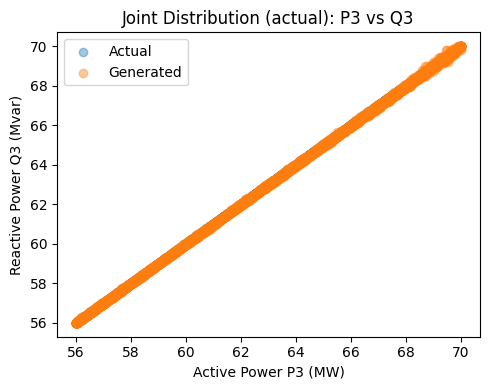

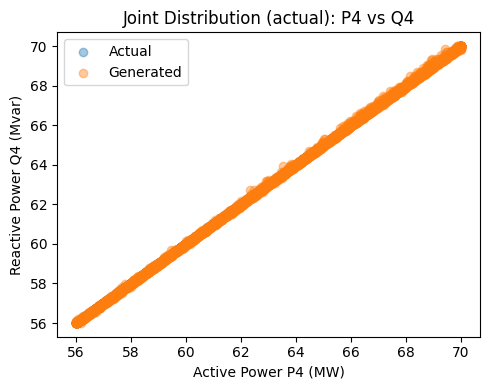

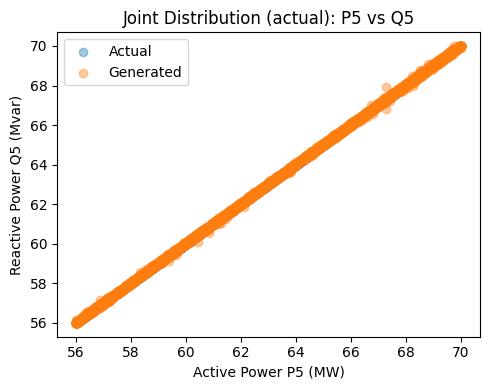


--- Wasserstein Distances ---
P0        : 0.041443
P1        : 0.121161
P2        : 0.173024
P3        : 0.065896
P4        : 0.199150
P5        : 0.157948
Q0        : 0.068785
Q1        : 0.122955
Q2        : 0.188441
Q3        : 0.076880
Q4        : 0.182741
Q5        : 0.173900
V0        : 0.000000
V1        : 0.000000
V2        : 0.000000
V3        : 0.011295
V4        : 0.043624
V5        : 0.037006
Theta0    : 0.000000
Theta1    : 0.003887
Theta2    : 0.003072
Theta3    : 0.003178
Theta4    : 0.003285
Theta5    : 0.004502

Mean Wasserstein Distance: 0.070091


2025-11-25 19:17:11.717193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764098231.876292      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764098231.922694      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


--- Multivariate Wasserstein-1 Distance (actual units) ---
Multivariate W1 distance = 0.028324


/usr/local/lib/python3.11/dist-packages/ot/lp/_network_simplex.py:332: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# -------------------------------
# User-defined constants
# -------------------------------
BASE_MVA = 100        # same base MVA as used in generation
# Load your pandapower net if you need voltage base
import pandapower as pp
# assume you have 'net' loaded already
# (you can load your system, e.g., net = pp.load_example("case9") )

# -------------------------------
# Load datasets
# -------------------------------
actual = pd.read_csv("/kaggle/input/case6-ieee/test_data_6.csv")
generated = pd.read_csv("ddpm_stochastic_constrained_generated.csv")
assert list(actual.columns) == list(generated.columns), "Columns mismatch!"

# -------------------------------
# Detect buses
# -------------------------------
p_cols = [c for c in actual.columns if c.startswith("P")]
q_cols = [c for c in actual.columns if c.startswith("Q")]
v_cols = [c for c in actual.columns if c.startswith("V")]
theta_cols = [c for c in actual.columns if c.startswith("Th")]

num_buses = len(p_cols)
print(f"\nDetected {num_buses} buses based on column naming (P1...P{num_buses}).")

# -------------------------------
# Convert per-unit → actual values
# -------------------------------
actual_nonpu = actual.copy()
generated_nonpu = generated.copy()

# Convert P and Q (per-unit → MW / Mvar)
for col in p_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

for col in q_cols:
    actual_nonpu[col] = actual[col] * BASE_MVA
    generated_nonpu[col] = generated[col] * BASE_MVA

# Convert V (per-unit → kV)
vn_kv = net.bus.vn_kv.values  # base voltage for each bus
for i, col in enumerate(v_cols):
    actual_nonpu[col] = actual[col] * vn_kv[i]
    generated_nonpu[col] = generated[col] * vn_kv[i]


print("\nConverted per-unit values to actual units (MW / Mvar / kV / degrees)")

for col in actual_nonpu.columns:
    plt.figure(figsize=(5,3))
    plt.hist(actual_nonpu[col], bins=40, alpha=0.6, density=True, label='Actual')
    plt.hist(generated_nonpu[col], bins=40, alpha=0.6, density=True, label='Generated')
    plt.title(f"Histogram comparison (actual units): {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in range(1, num_buses + 1):
    p_col = f"P{i}"
    q_col = f"Q{i}"
    v_col = f"V{i}"
    th_col = f"Th{i}"

    if all(c in actual_nonpu.columns for c in [p_col, q_col]):
        plt.figure(figsize=(5,4))
        plt.scatter(actual_nonpu[p_col], actual_nonpu[q_col], alpha=0.4, label="Actual")
        plt.scatter(generated_nonpu[p_col], generated_nonpu[q_col], alpha=0.4, label="Generated")
        plt.xlabel(f"Active Power {p_col} (MW)")
        plt.ylabel(f"Reactive Power {q_col} (Mvar)")
        plt.title(f"Joint Distribution (actual): {p_col} vs {q_col}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if all(c in actual_nonpu.columns for c in [v_col, th_col]):
        plt.figure(figsize=(5,4))
        plt.scatter(actual_nonpu[v_col], actual_nonpu[th_col], alpha=0.4, label="Actual")
        plt.scatter(generated_nonpu[v_col], generated_nonpu[th_col], alpha=0.4, label="Generated")
        plt.xlabel(f"Voltage Magnitude {v_col} (kV)")
        plt.ylabel(f"Voltage Angle {th_col} (degrees)")
        plt.title(f"Joint Distribution (actual): {v_col} vs {th_col}")
        plt.legend()
        plt.tight_layout()
        plt.show()

print("\n--- Wasserstein Distances ---")
distances = {}
for col in actual_nonpu.columns:
    wdist = wasserstein_distance(actual_nonpu[col], generated_nonpu[col])
    distances[col] = wdist
    print(f"{col:<10}: {wdist:.6f}")
print(f"\nMean Wasserstein Distance: {np.mean(list(distances.values())):.6f}")

import ot

print("\n--- Multivariate Wasserstein-1 Distance (actual units) ---")

# Convert the full datasets into matrices
X = actual.values       # shape (N, d)
Y = generated.values    # shape (M, d)

# Cost matrix C_ij = ||X_i - Y_j||
C = ot.dist(X, Y, metric='euclidean')

# Uniform probability masses
a = np.ones(X.shape[0]) / X.shape[0]
b = np.ones(Y.shape[0]) / Y.shape[0]

# Solve optimal transport
gamma = ot.emd(a, b, C)

# W1 = Σ γ_ij * C_ij
W1_multivariate = np.sum(gamma * C)

print(f"Multivariate W1 distance = {W1_multivariate:.6f}")


In [9]:
from scipy.stats import entropy
import numpy as np
import pandas as pd

def kl_divergence_featurewise(actual_df, gen_df, bins=80, eps=1e-12):
    """
    Computes KL divergence feature-wise:
        KL( actual_feature || generated_feature )
    Also converts Theta columns from degrees → radians.
    """
    actual = actual_df.copy()
    gen = gen_df.copy()

    # ------------------------------
    # Convert Theta columns to radians
    # ------------------------------
    theta_cols = [c for c in actual.columns if "Theta" in c]

    if len(theta_cols) > 0:
        actual[theta_cols] = np.deg2rad(actual[theta_cols])
        gen[theta_cols] = np.deg2rad(gen[theta_cols])

    # ------------------------------
    # KL Divergence per feature
    # ------------------------------
    cols = actual.columns.tolist()
    data_gt = actual.values
    data_syn = gen.values

    kl_results = {}

    for i, col in enumerate(cols):
        real_vals = data_gt[:, i]
        test_vals = data_syn[:, i]

        # Shared histogram range
        hist_range = (
            min(real_vals.min(), test_vals.min()),
            max(real_vals.max(), test_vals.max())
        )

        real_hist, _ = np.histogram(real_vals, bins=bins, range=hist_range, density=True)
        test_hist, _ = np.histogram(test_vals, bins=bins, range=hist_range, density=True)

        real_hist += eps
        test_hist += eps

        real_hist /= real_hist.sum()
        test_hist /= test_hist.sum()

        kl = entropy(real_hist, test_hist)
        kl_results[col] = kl

    return pd.DataFrame(kl_results, index=["KL"]).T
    
kl = kl_divergence_featurewise(actual, generated)
print(kl)
print(kl["KL"].mean())

              KL
P0      0.088022
P1      0.028234
P2      0.025974
P3      0.021065
P4      0.017722
P5      0.012922
Q0      0.016799
Q1      0.024763
Q2      0.016806
Q3      0.021496
Q4      0.017860
Q5      0.013825
V0      0.000000
V1      0.000000
V2      0.000000
V3      0.014547
V4      0.012192
V5      0.022711
Theta0  1.058430
Theta1  0.042398
Theta2  0.030260
Theta3  0.074810
Theta4  0.044553
Theta5  0.033891
0.06830335298912744
